In [1]:
import os
import numpy as np
import cv2
from pyswarm import pso

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
from pyswarm import pso
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Paths ---
csv_path = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/label.csv"
image_dir = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared"

In [3]:
# --- 1. Load CSV ---
df = pd.read_csv(csv_path)
df['filepath'] = df['Filename'].apply(lambda x: os.path.join(image_dir, x))
print(f"Total samples from CSV: {len(df)}")

Total samples from CSV: 15101


In [4]:
# --- 2. Extract raw features from images ---
def extract_image_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (64, 64)).astype(np.float32) / 255.0
    return image.flatten()

X = np.array([extract_image_features(p) for p in df['filepath']])
y = df['Vmax'].values

print(f"Raw feature shape: {X.shape}")  # (samples, features)
print(f"Labels shape: {y.shape}")

Raw feature shape: (15101, 4096)
Labels shape: (15101,)


In [5]:
# --- 3. PSO for feature selection ---
def pso_feature_selection(X, y, num_features=200):
    dim = X.shape[1]

    def objective_function(mask):
        mask = mask > 0.5
        if np.sum(mask) == 0:
            return float('inf')
        X_selected = X[:, mask]
        weights = np.linalg.pinv(X_selected) @ y
        predictions = X_selected @ weights
        return np.mean((predictions - y) ** 2)

    lb = [0] * dim
    ub = [1] * dim
    best_mask, _ = pso(objective_function, lb, ub, swarmsize=30, maxiter=10)
    selected_features = best_mask > 0.5
    return selected_features

selected_mask = pso_feature_selection(X, y)
print(f"Selected features count: {np.sum(selected_mask)}")

X_selected = X[:, selected_mask]
print(f"Feature shape after PSO selection: {X_selected.shape}")

Stopping search: maximum iterations reached --> 10
Selected features count: 2141
Feature shape after PSO selection: (15101, 2141)


In [6]:
# Save selected mask for reuse
np.save("selected_features_mask.npy", selected_mask)

In [7]:
# --- Train / Val / Test Split ---
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

Train: 10909 | Val: 1926 | Test: 2266


In [8]:
# --- Convert to Tensors ---
def to_loader(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)

train_loader = to_loader(X_train, y_train)
val_loader = to_loader(X_val, y_val)


In [9]:
# --- Model ---
class FeatureCNN(nn.Module):
    def __init__(self, input_size):
        super(FeatureCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

device = torch.device('cpu')
model = FeatureCNN(X_selected.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
import time
# --- Training ---
print("Starting Training...\n")
train_losses = []
val_losses = []
for epoch in range(1, 51):
    start_time = time.time()
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {elapsed:.2f}s")


Starting Training...

Epoch 01 | Train Loss: 1148.6876 | Val Loss: 888.7360 | Time: 1.41s
Epoch 02 | Train Loss: 798.1043 | Val Loss: 748.6962 | Time: 1.16s
Epoch 03 | Train Loss: 758.2237 | Val Loss: 718.1609 | Time: 1.32s
Epoch 04 | Train Loss: 736.0458 | Val Loss: 733.7414 | Time: 1.31s
Epoch 05 | Train Loss: 719.4495 | Val Loss: 716.1112 | Time: 1.26s
Epoch 06 | Train Loss: 705.8031 | Val Loss: 681.1753 | Time: 1.31s
Epoch 07 | Train Loss: 696.0260 | Val Loss: 688.4213 | Time: 1.31s
Epoch 08 | Train Loss: 690.3462 | Val Loss: 668.8929 | Time: 1.32s
Epoch 09 | Train Loss: 684.0483 | Val Loss: 670.0667 | Time: 1.31s
Epoch 10 | Train Loss: 677.0720 | Val Loss: 662.6084 | Time: 1.34s
Epoch 11 | Train Loss: 660.6493 | Val Loss: 652.8277 | Time: 1.33s
Epoch 12 | Train Loss: 670.0776 | Val Loss: 649.3148 | Time: 1.30s
Epoch 13 | Train Loss: 658.0741 | Val Loss: 680.7856 | Time: 1.27s
Epoch 14 | Train Loss: 649.7286 | Val Loss: 679.4731 | Time: 1.29s
Epoch 15 | Train Loss: 646.1736 | Val L

In [11]:
# --- Evaluation on All Sets ---
def evaluate(name, X, y):
    model.eval()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        preds = model(X_tensor).squeeze().numpy()
    mse = mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"{name} Set:")
    print(f"  MSE: {mse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²:  {r2:.4f}\n")

evaluate("Train", X_train, y_train)
evaluate("Validation", X_val, y_val)
evaluate("Test", X_test, y_test)

Train Set:
  MSE: 616.88
  MAE: 17.60
  R²:  0.4792

Validation Set:
  MSE: 693.54
  MAE: 18.58
  R²:  0.4250

Test Set:
  MSE: 738.04
  MAE: 18.90
  R²:  0.3740



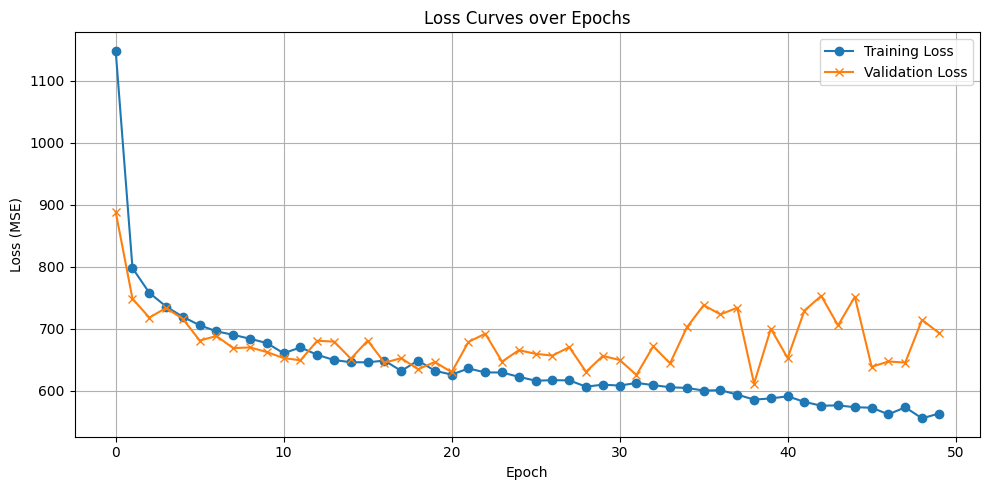

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("Loss Curves over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# --- Save Model ---
torch.save(model.state_dict(), "pso_cnn_model_3.pth")
print("Model saved as 'pso_cnn_model_3.pth'")

Model saved as 'pso_cnn_model_3.pth'


New image feature shape: (2141,)


C:\Users\satvi\AppData\Local\Temp\ipykernel_11580\3854485769.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pso_cnn_model_3.pth", map

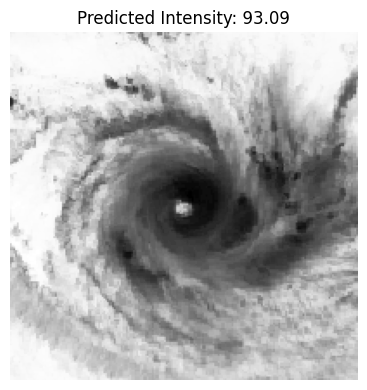

93.08541870117188

In [14]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming FeatureCNN is already defined elsewhere
# and selected_features_mask.npy + pso_cnn_model.pth are available

def predict_new_image(image_path):
    # Load and preprocess image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, (64, 64)).astype(np.float32) / 255.0
    features = image_resized.flatten()

    # Load selected features mask
    selected_mask = np.load("selected_features_mask.npy") > 0.5
    selected_feat = features[selected_mask]
    print(f"New image feature shape: {selected_feat.shape}")

    # Load model
    model = FeatureCNN(selected_feat.shape[0])
    model.load_state_dict(torch.load("pso_cnn_model_3.pth", map_location=torch.device('cpu')))
    model.eval()

    # Predict
    with torch.no_grad():
        input_tensor = torch.tensor(selected_feat, dtype=torch.float32).unsqueeze(0)
        prediction = model(input_tensor).item()

    # Display image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Intensity: {prediction:.2f}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return prediction

# Example usage:
new_image = "D:/B.Tech/8th Sem/CI Lab/Project/Cylone_Intensity_IndianOcean/Infrared/IN_1.png"
predict_new_image(new_image)